# Random Forest

In [89]:
import os
import sys
from pathlib import Path

from IPython.display import display, HTML, Markdown
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Project level imports
sys.path.insert(0, '../lib')
from ncbi_remap.notebook import Nb
from ncbi_remap.plotting import make_figs

In [2]:
# Setup notebook
nbconfig = Nb.setup_notebook()

Please check output/fbgn2chrom.tsv. If it does not exist, run bin/fbgn2chrom.py
last updated: 2018-10-01 
Git hash: e661446c073541ec5d8ce0ef424e3221bd0e4094


In [3]:
# Connect to data store
store = pd.HDFStore('../output/sra.h5', mode='r')

In [4]:
from pymongo import MongoClient
try:
    with open('../output/.mongodb_host', 'r') as fh:
        host = fh.read().strip()
except FileNotFoundError:
    host = 'localhost'

mongoClient = MongoClient(host=host, port=27017)
db = mongoClient['sra']
ncbi = db['ncbi']

In [5]:
# Set of figures
mpl.rcParams['figure.figsize'] = 7, 7
mpl.rcParams['figure.titlesize'] = 12
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['font.size'] = 12
mpl.rcParams['grid.linewidth'] = 1.3
mpl.rcParams['legend.fontsize'] = 8.0
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['axes.titlesize'] = 11
mpl.rcParams['axes.titleweight'] = 'bold'
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markeredgewidth'] = 0.02
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['patch.linewidth'] = 2
mpl.rcParams['xtick.labelsize'] = 10.0
mpl.rcParams['xtick.major.pad'] = 9.1
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.labelsize'] = 10.0
mpl.rcParams['ytick.major.pad'] = 9.1
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.width'] = 1

In [8]:
complete_srx = store['aln/complete'].srx.unique().tolist()

## Pull Out Library Strategy

In [9]:
libstrat = pd.DataFrame(list(ncbi.aggregate([
    {
        '$match': {
            '_id': {'$in': complete_srx},
        }
    },
    {
        '$unwind': {
            'path': "$runs"
        }
    },
    {
        '$project': {
            '_id': 0,
            'srx': '$srx',
            'srr': '$runs.srr',
            'library_strategy': '$sra.experiment.library_strategy'
        }
    }
]))).set_index(['srx', 'srr'])

libstrat_srx = libstrat.reset_index().groupby('srx').first().library_strategy

In [10]:
srrs = libstrat.index.get_level_values('srr')
srxs = libstrat_srx.index

## Build Feature Table

In [11]:
# collect RNA-seq metrics
cols = [
    'PCT_CODING_BASES',
    'PCT_UTR_BASES',
    'PCT_INTRONIC_BASES',
    'PCT_INTERGENIC_BASES',
    'PCT_MRNA_BASES',
    'MEDIAN_CV_COVERAGE',
    'MEDIAN_5PRIME_BIAS',
    'MEDIAN_3PRIME_BIAS'
]

cm = store.select('prealn/workflow/collectrnaseqmetrics/unstranded', where='srx == srxs', columns=cols)

# collect RNA-seq metrics gene body coverage
gb = store.select('prealn/workflow/collectrnaseqmetrics/genebody', where='srx == srxs')

# markduplicates
cols = [
    'PERCENT_DUPLICATION',
]

mark = store.select('prealn/workflow/markduplicates', where='srx == srxs', columns=cols)

# feature counts summary
cols = [
    'Assigned',
    'Unassigned_Ambiguity',
    'Unassigned_MultiMapping',
    'Unassigned_NoFeatures',
    'Unassigned_Unmapped'
]

feature_summary = store.select('prealn/workflow/feature_counts/summary', columns=cols, where='srx == srxs')

# Munge together
dat_by_srr = cm.join(gb).join(mark).join(feature_summary)
dat_by_srr_no_na = dat_by_srr.fillna(dat_by_srr.mean().to_dict(), axis=0)
dat_by_srr_no_na.shape

# Coverage counts
genic = pd.read_parquet('../output/aln-downstream-wf/aggregate_genic_counts.parquet').reindex(srxs)['count']
genic.name = 'genic'
genic = genic.astype(np.float64)

intergenic = pd.read_parquet('../output/aln-downstream-wf/aggregate_intergenic_counts.parquet').reindex(srxs)['count']
intergenic.name = 'intergenic'
intergenic = intergenic.astype(np.float64)

junctions = pd.read_parquet('../output/aln-downstream-wf/aggregate_junction_counts.parquet').reindex(srxs)['count']
junctions.name = 'junctions'
junctions = junctions.astype(np.float64)

coverage = pd.concat([genic, intergenic, junctions], axis=1)

# Make feature set with all features
features = dat_by_srr_no_na.reset_index().groupby('srx').mean().join(coverage)

In [103]:
# Only look at things we have features for
Y = libstrat_srx.reindex(features.index)

# split out the OTHER category
Y_OTHER = Y[Y == 'OTHER'].copy()
features_OTHER = features.reindex(Y_OTHER.index).dropna()

Y = Y[(Y != 'OTHER') & (Y != 'CLONE')].copy()
features = features.reindex(Y.index)

In [104]:
def perturb_sample(Y, frac=0.05):
    """Pull out a fraction of RNA-Seq and change to ChIP-Seq."""
    rnaseq = Y[(Y == 'RNA-Seq')].index
    n_rnaseq = rnaseq.shape[0]
    n_perturb = int(np.floor(n_rnaseq * frac))
    perturb_srx = np.random.choice(rnaseq, n_perturb)
    Yp = Y.copy()
    Yp.loc[perturb_srx] = 'ChIP-Seq'
    return Yp

def build_model(features, Y_enc):
    # Make training and testing datasets
    X_train, X_test, Y_train, Y_test = train_test_split(features, Y_enc)

    classifier_pipeline = Pipeline([
        ('scale', StandardScaler()),
        ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
    ])

    classifier_pipeline.fit(X_train, Y_train)

    # Test
    Y_test_pred = classifier_pipeline.predict(X_test)
    return accuracy_score(Y_test, Y_test_pred)

In [91]:
build_model(features, Y_enc)

0.72261110206739376

In [92]:
encoder = LabelEncoder().fit(Y)

fracs = np.linspace(0, 50, 11) / 100
res = []
for frac in fracs:
    if frac == 0:
        _Y = Y.copy()
    else:
        _Y = perturb_sample(Y, frac)

    # Encode labels
    Y_enc = encoder.transform(_Y)
    res.append([frac, build_model(features, Y_enc)])

In [93]:
accuracy = pd.DataFrame(res, columns=['% Miss Classified', 'Accuracy']).set_index('% Miss Classified')

Text(0.5,1,'Accuracy with Increased Miss-Classificiation')

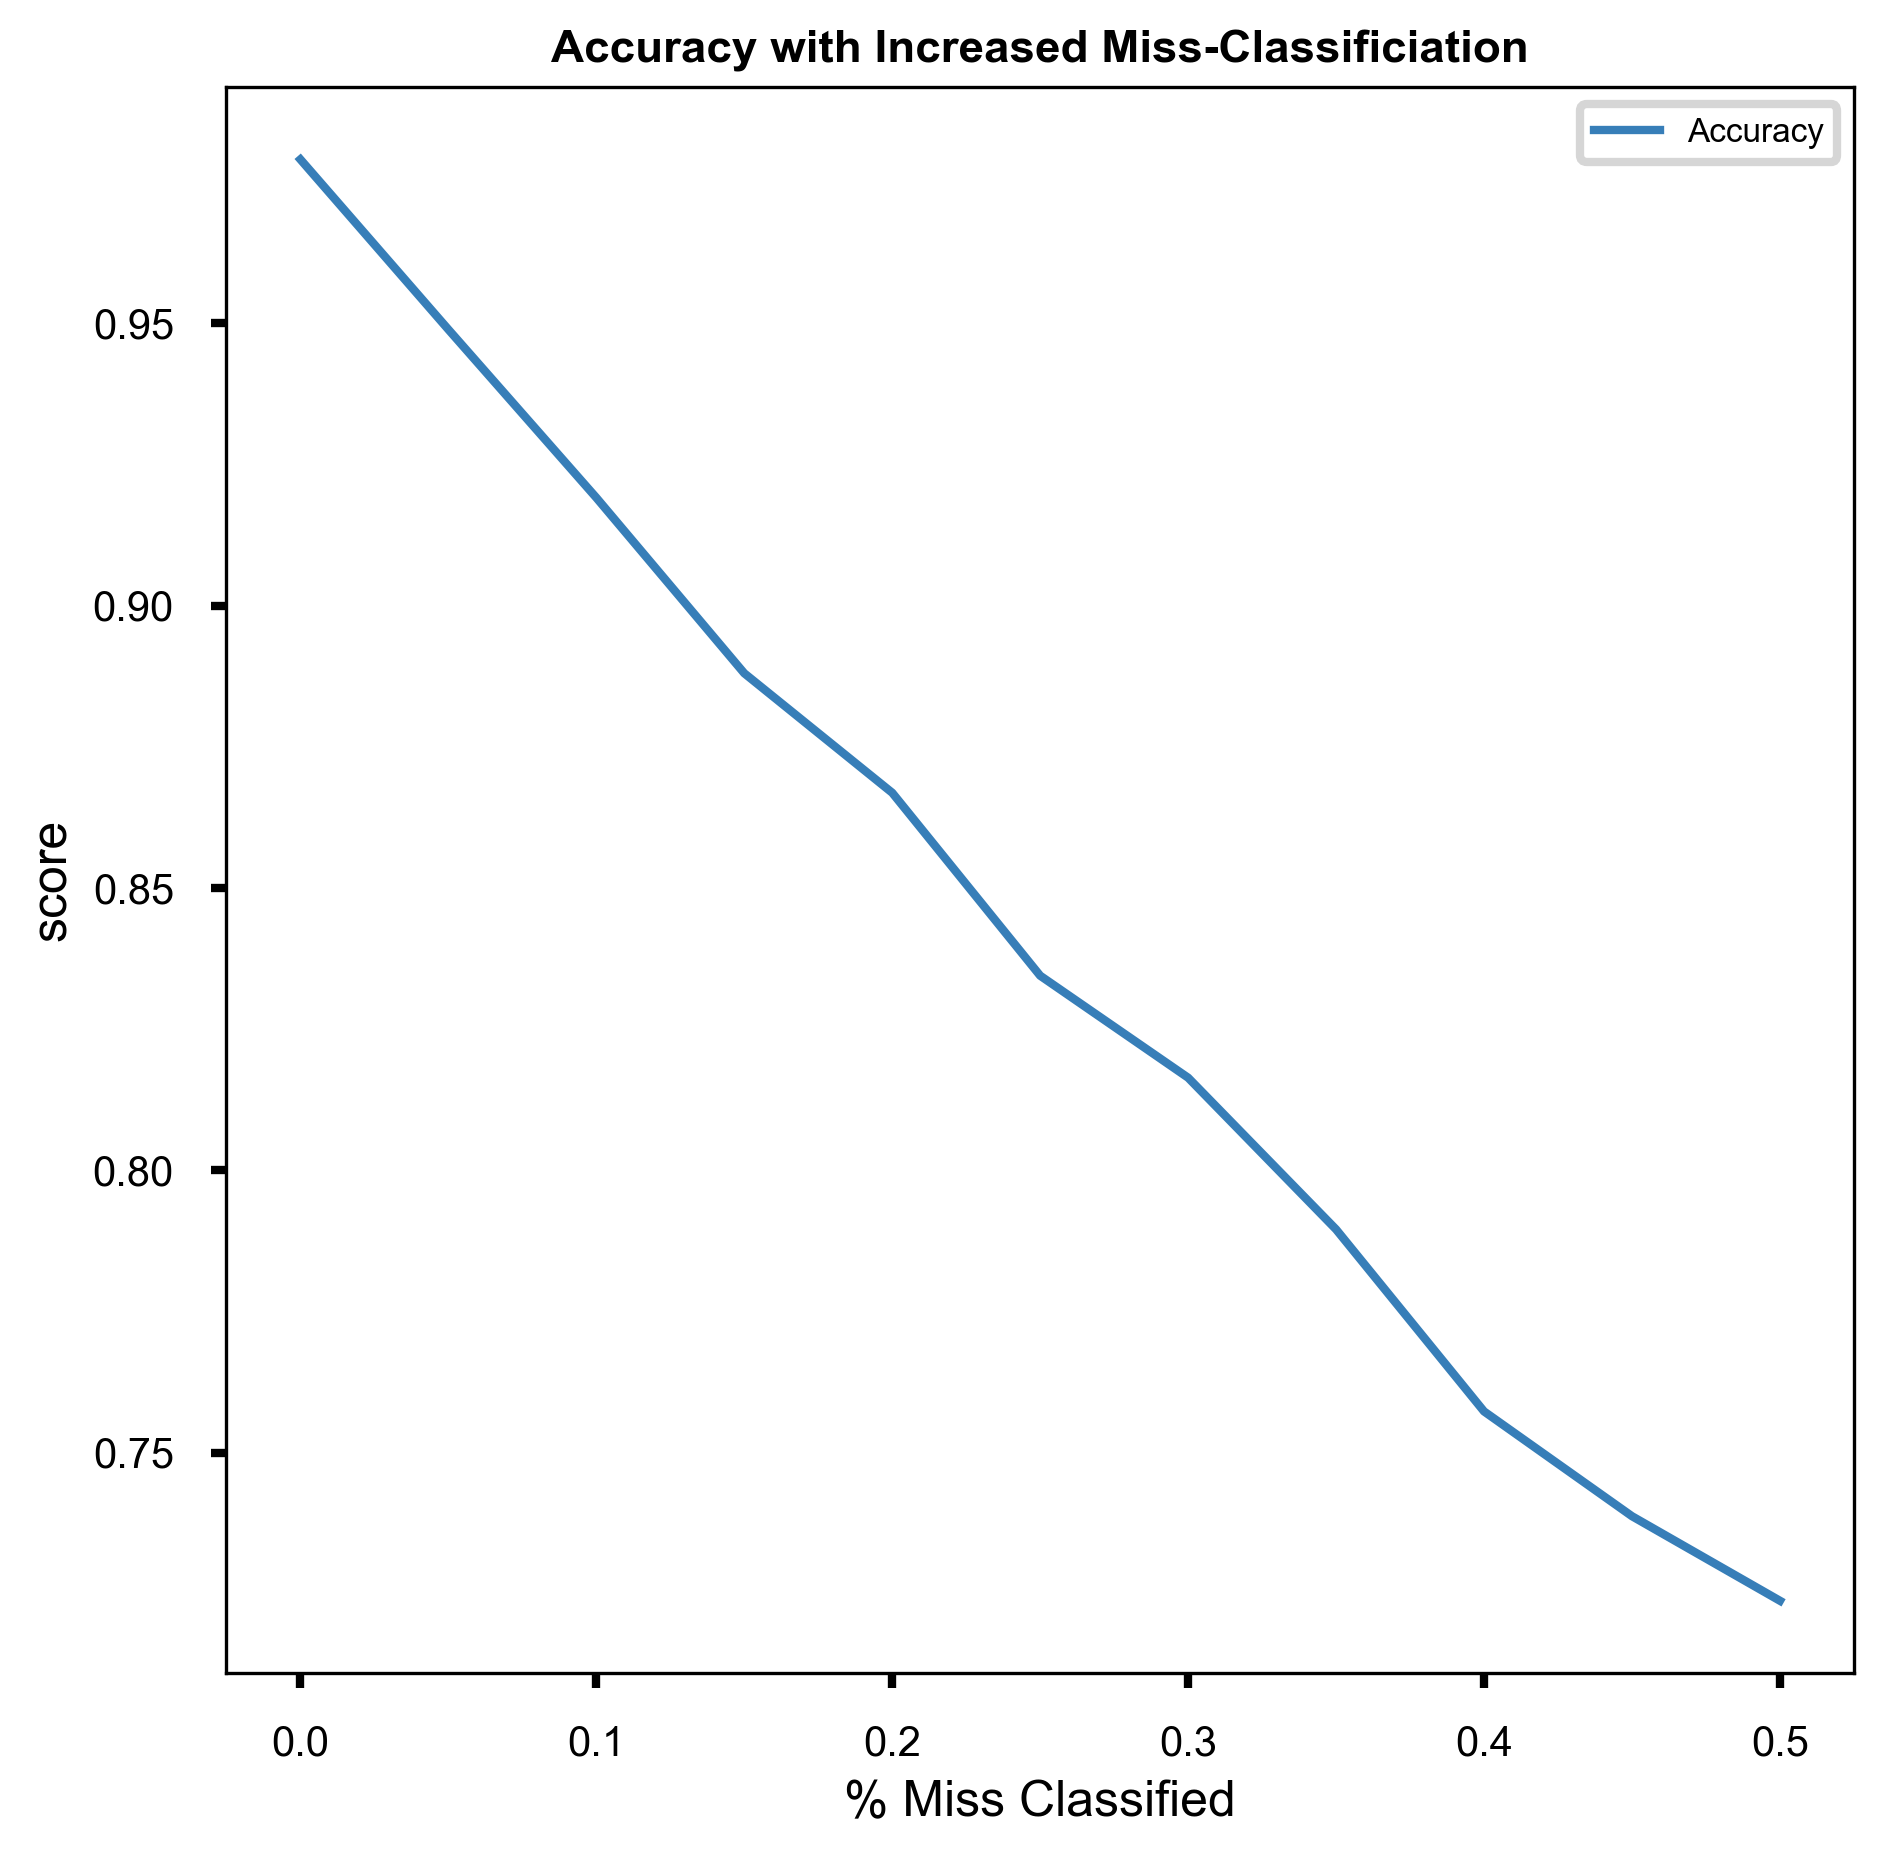

In [94]:
ax = accuracy.plot()
ax.set_ylabel('score')
ax.set_title('Accuracy with Increased Miss-Classificiation')

In [116]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedShuffleSplit, cross_validate, validation_curve
clf = make_pipeline(StandardScaler(), PCA(n_components=10), RandomForestClassifier(n_estimators=100, random_state=42))

In [113]:
cv = StratifiedShuffleSplit(n_splits=20)
scores = cross_validate(clf, features, Y, cv=cv, n_jobs=10, return_train_score=True)
scores

{'fit_time': array([ 19.89648,  20.46681,  20.34708,  21.48336,  20.06273,  22.22664,
         22.10414,  22.15689,  21.26832,  21.23152,  18.78524,  19.07235,
         19.24045,  19.814  ,  19.98346,  20.17126,  19.92643,  21.16734,
         19.75598,  19.28039]),
 'score_time': array([ 0.56979,  0.43932,  0.4034 ,  0.30826,  0.45475,  0.19348,
         0.23991,  0.23957,  0.32351,  0.31653,  0.51829,  0.34258,
         0.42014,  0.34797,  0.3697 ,  0.26592,  0.21988,  0.08521,
         0.07242,  0.07954]),
 'test_score': array([ 0.96133,  0.96174,  0.95686,  0.965  ,  0.95808,  0.96296,
         0.95808,  0.96093,  0.95767,  0.95604,  0.96011,  0.96052,
         0.95849,  0.95808,  0.95889,  0.95726,  0.95686,  0.96052,
         0.9593 ,  0.95849]),
 'train_score': array([ 1.     ,  1.     ,  1.     ,  1.     ,  1.     ,  1.     ,
         0.99995,  1.     ,  1.     ,  1.     ,  1.     ,  1.     ,
         1.     ,  1.     ,  1.     ,  1.     ,  1.     ,  1.     ,
         0.99995,  

Text(0.5,0,'Iteration')

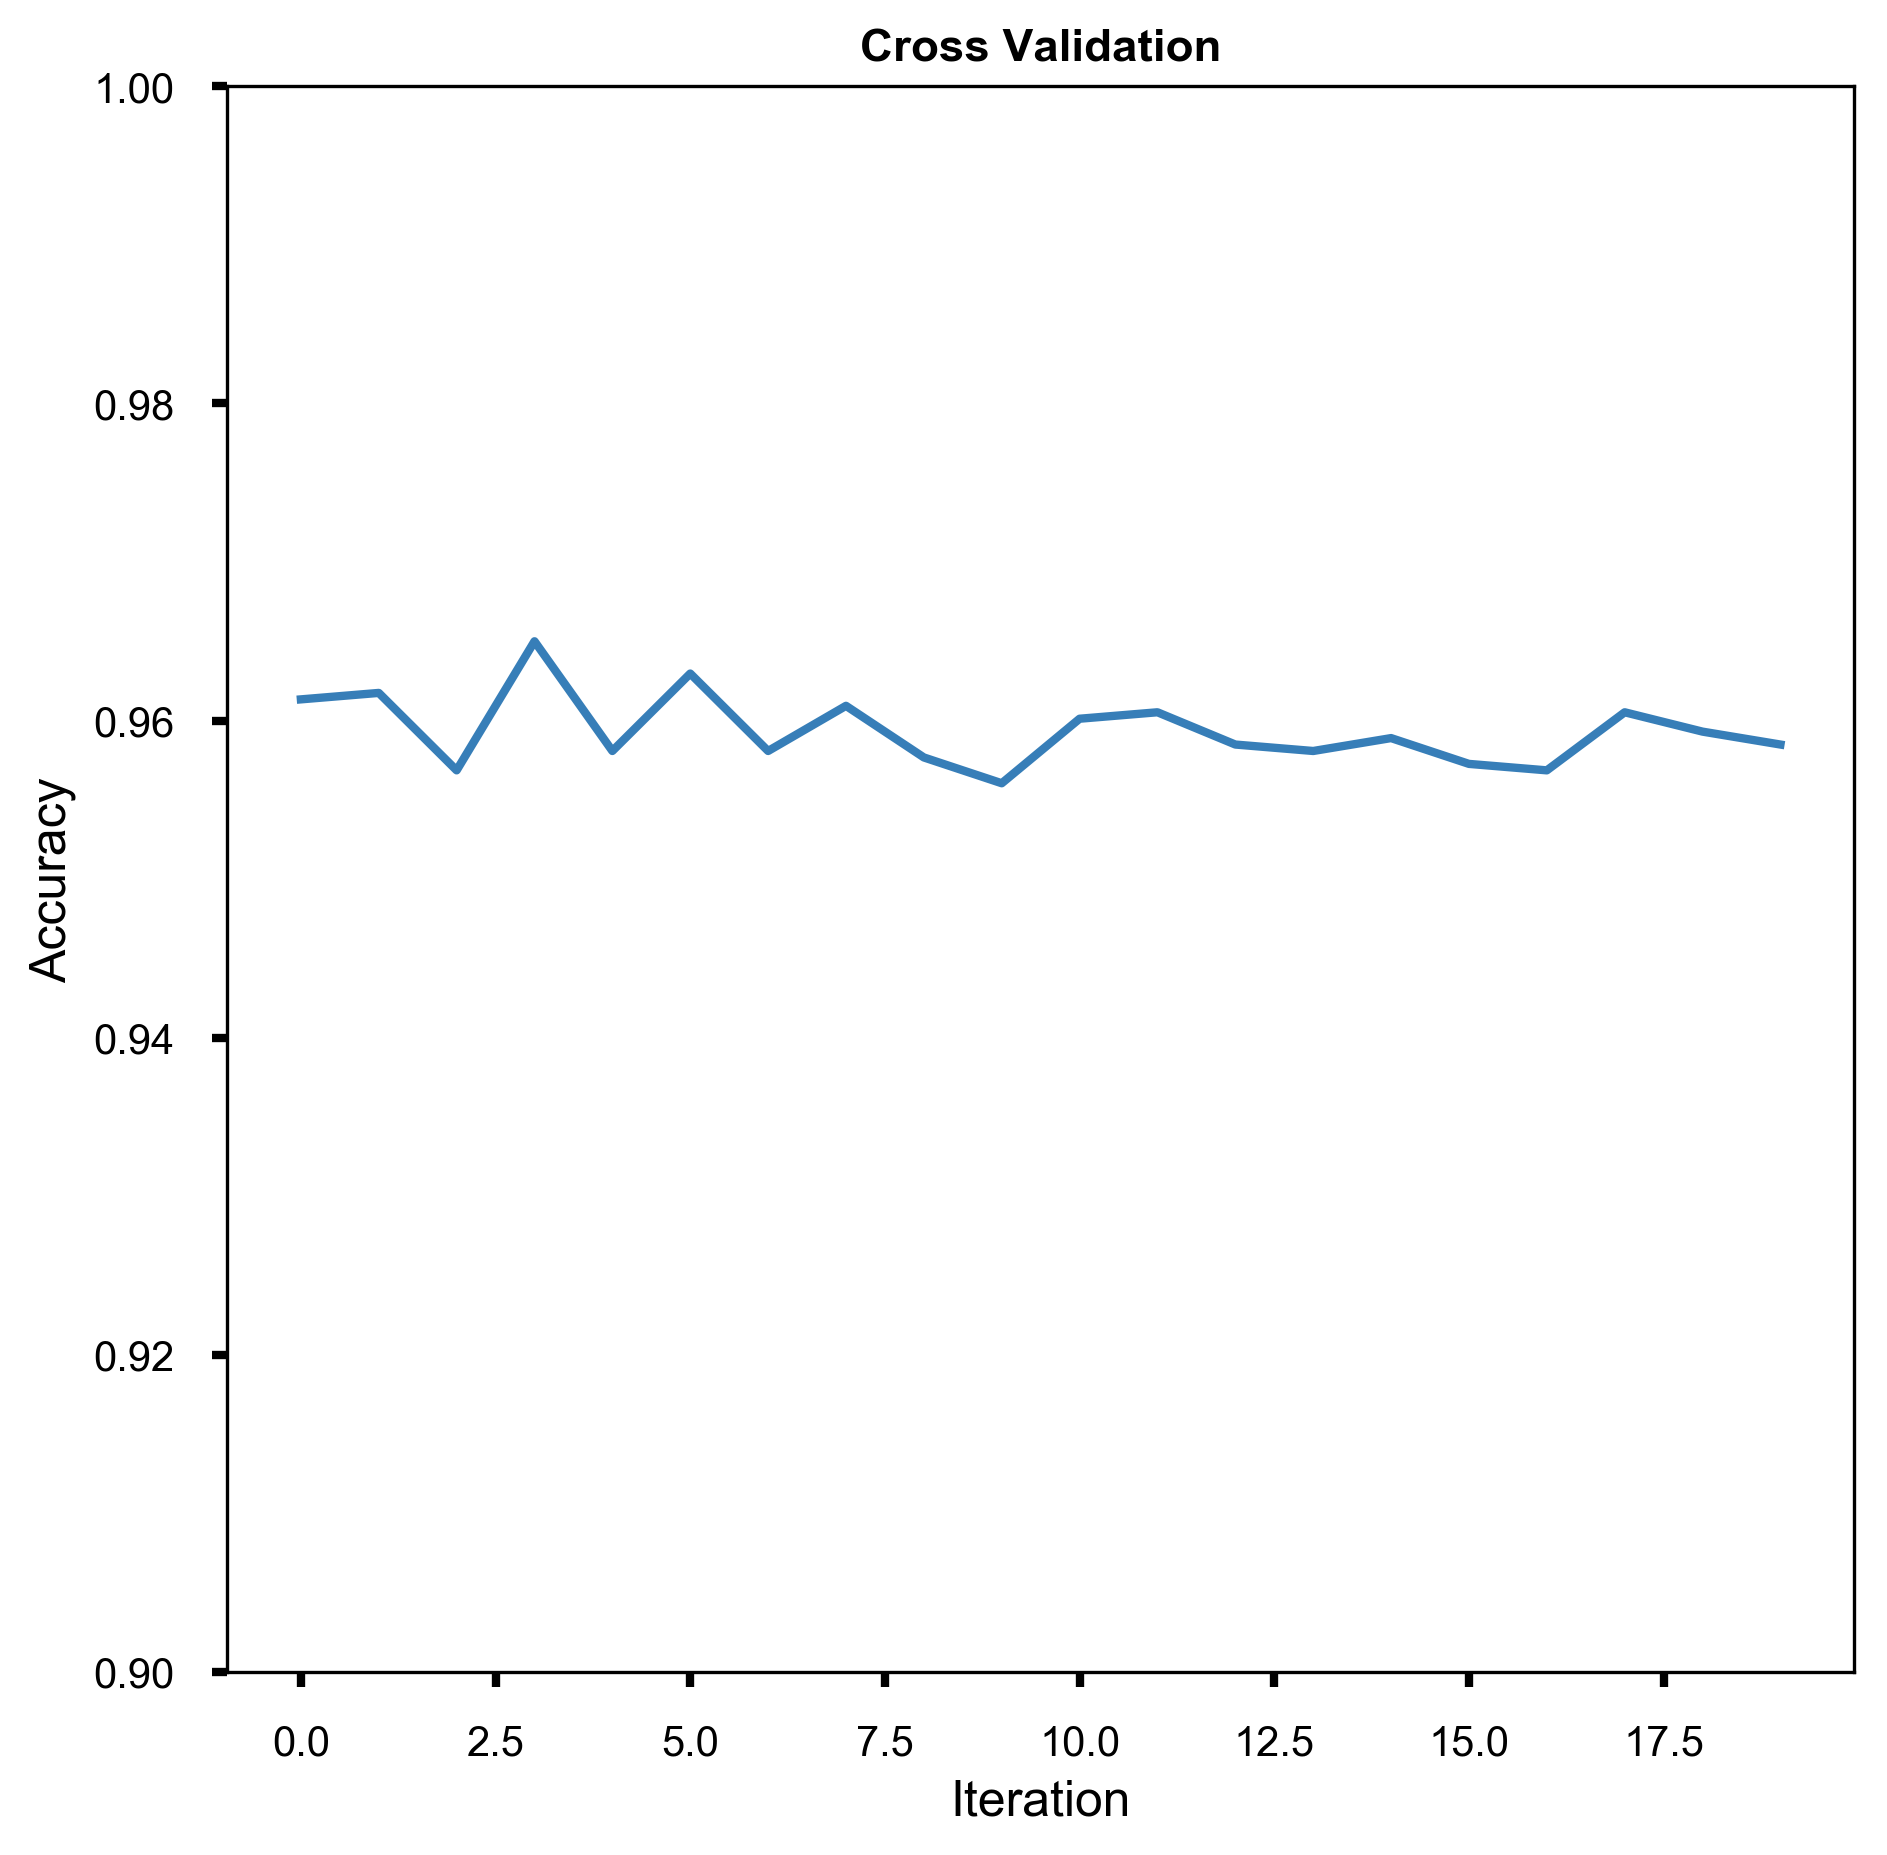

In [125]:
plt.plot(scores['test_score'])
ax = plt.gca()
ax.set_ylim(.9, 1)
ax.set_title('Cross Validation')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Iteration')

In [132]:
Y_enc = encoder.fit_transform(Y)
X_train, X_test, Y_train, Y_test = train_test_split(features, Y_enc)
clf.fit(X_train, Y_train)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, cr...ators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False))])

In [134]:
Y_pred = clf.predict(features)

In [140]:
rf_df = pd.DataFrame(encoder.inverse_transform(Y_pred), index=features.index, columns=['prediction'])

In [142]:
rf_df = rf_df.join(libstrat_srx)

In [146]:
miss = rf_df[rf_df.prediction != rf_df.library_strategy]

In [148]:
miss.query('library_strategy == "RNA-Seq"')

,prediction,library_strategy
srx,,
SRX002600,EST,RNA-Seq
SRX002601,EST,RNA-Seq
SRX026304,ChIP-Seq,RNA-Seq
SRX026307,ChIP-Seq,RNA-Seq
SRX032510,EST,RNA-Seq
SRX032518,EST,RNA-Seq
SRX032546,EST,RNA-Seq
SRX032570,EST,RNA-Seq
SRX1006565,EST,RNA-Seq


In [152]:
miss.query('library_strategy == "ChIP-Seq"').sort_values(by='prediction')

,prediction,library_strategy
srx,,
SRX040615,EST,ChIP-Seq
SRX197566,EST,ChIP-Seq
SRX1847042,EST,ChIP-Seq
SRX883601,RNA-Seq,ChIP-Seq
ERX011415,RNA-Seq,ChIP-Seq
ERX011416,RNA-Seq,ChIP-Seq
SRX386678,RNA-Seq,ChIP-Seq
ERX242715,RNA-Seq,ChIP-Seq
SRX595765,RNA-Seq,ChIP-Seq
